In [0]:
%%bash
ps -ef | grep "python3" | awk '{print $2}' | xargs kill
ps ax | grep python

In [57]:
%%bash
git config --global user.email 'yerong.li@outlook.com'
git config --global user.name 'Yerong'
git clone git@bitbucket.org:YerongLeopard/metric-learning.git
ls

checkpoint
datalab
fig0.png
fig1000.png
fig500.png
MNIST_data
mnist.pkl
model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta


Cloning into 'metric-learning'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


Python code blocks

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  I Proc size: 141.6 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import itertools as it
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt

import time
start_time = time.time()
max_step = 1000
test_itv = 200
plot_itv = 500
test_batch_size = 1000
model_dir = "./model.ckpt"
class MnistData():
    """
    Arrange MNIST data set to suit siamese networking training
    """
    def __init__(self):
        try:
            with open('mnist.pkl', 'rb') as file:
                mnist = pkl.load(file)
        except IOError:
            mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
            with open('mnist.pkl', 'wb') as file:
                pkl.dump(mnist, file)

        self.train_images = mnist.train.images.reshape((-1, 28, 28, 1))
        self.train_labels = mnist.train.labels
        self.test_images = mnist.test.images.reshape((-1, 28, 28, 1))
        self.test_labels = mnist.test.labels

        self.train_amt = self.train_images.shape[0]
        self.test_amt = self.test_images.shape[0]

        self.images_in_label = [[] for i in range(10)]

        for i in range(self.train_amt):
            self.images_in_label[self.train_labels[i]].append(i)


    def get_siamese_train_batch(self):
        left_images = []
        right_images = []
        labels = []
        for i in range(10):
            n = 45
            l = np.random.choice(self.images_in_label[i], n * 2, replace=False).tolist()
            left_images.append(self.train_images[l.pop(), :, :, :])
            right_images.append(self.train_images[l.pop(), :, :, :])
            labels.append([1])

        # impostor
        for i, j in it.combinations(range(10), 2):
            l = [np.random.choice(self.images_in_label[i]), np.random.choice(self.images_in_label[j])]
            left_images.append(self.train_images[l.pop(), :, :, :])
            right_images.append(self.train_images[l.pop(), :, :, :])
            labels.append([0])
        return left_images, right_images, labels

    def get_triplet_train_batch(self):
        mid_images = []
        pos_images = []
        neg_images = []
        n = 5
        for i in range(10):
            for j in range(10):
                if j != i:
                    l_yes = np.random.choice(self.images_in_label[i], n * 2, replace=False).tolist()
                    l_no = np.random.choice(self.images_in_label[j], n, replace=False).tolist()
                    for k in range(n):
                        mid_images.append(self.train_images[l_yes.pop(), :, :, :])
                        pos_images.append(self.train_images[l_yes.pop(), :, :, :])
                        neg_images.append(self.train_images[l_no.pop(), :, :, :])
        return mid_images, pos_images, neg_images

    def get_test(self):
        return self.test_images, self.test_labels

class Network:
    """
    Build a convolutional network
    """

    def __init__(self, width, height, nch = 1, target = 2):
        """
        :param width: width of input images
        :param height: height of input images
        :param nch: number of channels of input images, by default, there is only one channel
        :param target: target dimensionality
        """
        # Projecting onto a 2D space, for plotting
        self.target = target
        self.width = self.cur_width = width
        self.height = self.cur_height = height
        self.nch = self.cur_nch = nch
        self.locked = False
        self.layers = []

    # Some utilities
    def weight_variable(self, _shape, _name):
        initial = tf.truncated_normal(_shape, stddev=0.1)
        return tf.Variable(initial, name=_name)

    def bias_variable(self, shape, name):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)

    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool(self, x, pool_width, pool_height):
        return tf.nn.max_pool(x, ksize=[1, pool_height, pool_width, 1], strides=[1, pool_height, pool_width, 1], padding='VALID')

    def add_conv(self, conv_width, conv_height, pool_width, pool_height, next_nch):
        """
        Add a convolutional layer to the network
        :param conv_width: width of conv kernel
        :param conv_height: height of conv kernel
        :param pool_width: width of max pooling
        :param pool_height: height of max pooling
        :param next_nch: number of channels of output
        """
        if self.locked:
            raise AssertionError('The network is connected. No more layer can be added.')

        if len(self.layers) > 0 and self.layers[-1]['type'] == 'fc':
            raise AssertionError('The data is flattened. No more conv layer can be added.')

        name = str(len(self.layers)) + '_conv_'
        W = self.weight_variable([conv_height, conv_width, self.cur_nch, next_nch], name + 'W')
        b = self.bias_variable([next_nch], name + 'b');

        self.layers.append({'W': W, 'b': b, 'p': (pool_width, pool_height), 'type': 'conv'})

        self.cur_height //= pool_height
        self.cur_width //= pool_width
        self.cur_nch = next_nch


    def add_fc(self, next_width):
        """
        Add a fully connected layer to the network
        :param next_width: dimensionality of the output
        """
        if self.locked:
            raise AssertionError('The network is connected. No more layer can be added.')

        if self.layers[-1]['type'] == 'conv':
            name = str(len(self.layers)) + '_ffc_'
            type = 'ffc'
            self.cur_width = self.cur_height * self.cur_width * self.cur_nch
            self.cur_height = self.cur_nch = 1
        else:
            name = str(len(self.layers)) + '_fc_'
            type = 'fc'
        W = self.weight_variable([self.cur_width, next_width], name + 'W')
        b = self.bias_variable([next_width], name + 'b')

        self.layers.append({'W': W, 'b': b, 'type': type})

        self.cur_width = next_width

    def connect(self, feed):
        """
        Connect the layers and return the output
        :param feed: input
        :return: output (tensorflow tensor)
        """
        act = tf.nn.tanh ## activation function is relu

        if not self.locked:
            name = str(len(self.layers)) + '_linear_'
            W = self.weight_variable([self.cur_width, self.target], name + 'W')
            b = self.bias_variable([self.target], name + 'b')
            self.layers.append({'W': W, 'b': b, 'type': 'linear'})
            del self.cur_width, self.cur_height, self.cur_nch

        for i in self.layers:
            if i['type'] == 'conv':
                print(i['W'], i['b'])
                feed = self.max_pool(act(self.conv2d(feed, i['W']) + i['b']), i['p'][0], i['p'][1])
            elif i['type'] == 'ffc':
                feed = act(tf.reshape(feed, [-1, int(i['W'].shape[0])]) @ i['W'] + i['b'])
            elif i['type'] == 'fc':
                feed = act(feed @ i['W'] + i['b'])
            elif i['type'] == 'linear':
                feed = feed @ i['W'] + i['b']
            else:
                raise AssertionError('Unknown layer type.')

        self.locked = True
        return feed

def test_mnist(step):
    pass


if __name__ == '__main__':
    data = MnistData() # Dataset
    net = Network(28, 28, 1) # Network

    # Add layers to the network
    net.add_conv(5, 5, 2, 2, 32)
    print(net.layers)
    net.add_conv(5, 5, 2, 2, 64)
    net.add_fc(1024) # the network will be flattened automatically
    net.add_fc(256)

    # Build Siamese structure, will use GPU to calculate when possible
    mid_input = tf.placeholder(tf.float32, [None, 28, 28, 1], name='mid_input')
    pos_input = tf.placeholder(tf.float32, [None, 28, 28, 1], name='pos_input')
    neg_input = tf.placeholder(tf.float32, [None, 28, 28, 1], name='neg_input')

    mid_output = net.connect(mid_input)
    pos_output = net.connect(pos_input)
    neg_output = net.connect(neg_input)

    # Use chunkize do run test (in case graphic memory is insufficient)

    test_input = tf.placeholder(tf.float32, [None, 28, 28, 1], name='test_input')
    test_output = net.connect(test_input)

    pos_exp_dist = tf.exp(tf.norm(mid_output - pos_output, axis=1, keep_dims=True))
    neg_exp_dist = tf.exp(tf.norm(mid_output - neg_output, axis=1, keep_dims=True))
    sum_exp_dist = pos_exp_dist + neg_exp_dist

    d_pos = pos_exp_dist / sum_exp_dist
    d_neg = neg_exp_dist / sum_exp_dist

    total_loss = tf.reduce_mean(d_pos ** 2) + tf.reduce_mean((d_neg - 1) ** 2)

    optimizer = tf.train.MomentumOptimizer(0.01, 0.99, use_nesterov=True).minimize(total_loss)
    # optimizer = tf.train.AdamOptimizer(0.001).minimize(total_loss)
    saver = tf.train.Saver()

    
    def plot(output, labels):
        colors =['r', 'b', 'g', 'k', 'brown', 'c','m', 'y', 'grey', 'orange']
        for j in range(10):
            plt.scatter(output[labels == j, 0], output[labels == j, 1], 5, color=colors[j])
        #plt.legend([str(i) for i in range(10)])
        #plt.savefig('fig' + str(num) + '.png')
        #plt.close()

    rec = []

    test_batch = data.get_triplet_train_batch()

    with tf.Session() as sess:
        try:
          saver.restore(sess, model_dir)
        except:
          sess.run(tf.global_variables_initializer())
        images, labels = data.get_test()
        chunks_img = [images[x:x+test_batch_size] for x in range(0, len(images), test_batch_size)]
        chunks_lbl = [labels[x:x+test_batch_size] for x in range(0, len(labels), test_batch_size)]
        for group in range(len(chunks_img)):    
          output = sess.run(test_output, feed_dict={test_input: chunks_img[group]})
          '''
          for j in range(10):
              plt.scatter(output[chunks_lbl[group] == j, 0], output[chunks_lbl[group] == j, 1], 5)
          '''
          plot(output, chunks_lbl[group])
        plt.legend([str(i) for i in range(10)])
        plt.savefig('fig0.png')
        plt.close()
        del images, labels, chunks_img, chunks_lbl
       

        
        
        for i in range(max_step):
            
            mid_images, pos_images, neg_images = data.get_triplet_train_batch()
            if (i + 1) % test_itv == 0:
                images, labels = data.get_test()
                _, loss = sess.run([optimizer, total_loss],
                                   feed_dict={mid_input: mid_images, pos_input: pos_images, neg_input: neg_images})
                print(i + 1, ': ', loss)
            else:
                sess.run(optimizer,
                         feed_dict={mid_input: mid_images, pos_input: pos_images, neg_input: neg_images})

            if (i + 1) % plot_itv == 0:
                images, labels = data.get_test()
                chunks_img = [images[x:x+test_batch_size] for x in range(0, len(images), test_batch_size)]
                chunks_lbl = [labels[x:x+test_batch_size] for x in range(0, len(labels), test_batch_size)]
                
                for group in range(len(chunks_img)):
                    output = sess.run(test_output, feed_dict={test_input: chunks_img[group]})
                    plot(output, chunks_lbl[group])
                plt.legend([str(idx) for idx in range(10)])
                plt.savefig('fig' + str(i + 1) + '.png')
                plt.close()
                del images, labels, chunks_img, chunks_lbl
                saver.save(sess, model_dir)
        saver.save(sess, model_dir)			
#        with open('triplet_output.pkl') as file:
#            pkl.dump([labels, rec], file);
        print("--- %s seconds ---" % (time.time() - start_time))     


[{'W': <tf.Variable '0_conv_W:0' shape=(5, 5, 1, 32) dtype=float32_ref>, 'b': <tf.Variable '0_conv_b:0' shape=(32,) dtype=float32_ref>, 'p': (2, 2), 'type': 'conv'}]
<tf.Variable '0_conv_W:0' shape=(5, 5, 1, 32) dtype=float32_ref> <tf.Variable '0_conv_b:0' shape=(32,) dtype=float32_ref>
<tf.Variable '1_conv_W:0' shape=(5, 5, 32, 64) dtype=float32_ref> <tf.Variable '1_conv_b:0' shape=(64,) dtype=float32_ref>
<tf.Variable '0_conv_W:0' shape=(5, 5, 1, 32) dtype=float32_ref> <tf.Variable '0_conv_b:0' shape=(32,) dtype=float32_ref>
<tf.Variable '1_conv_W:0' shape=(5, 5, 32, 64) dtype=float32_ref> <tf.Variable '1_conv_b:0' shape=(64,) dtype=float32_ref>
<tf.Variable '0_conv_W:0' shape=(5, 5, 1, 32) dtype=float32_ref> <tf.Variable '0_conv_b:0' shape=(32,) dtype=float32_ref>
<tf.Variable '1_conv_W:0' shape=(5, 5, 32, 64) dtype=float32_ref> <tf.Variable '1_conv_b:0' shape=(64,) dtype=float32_ref>
<tf.Variable '0_conv_W:0' shape=(5, 5, 1, 32) dtype=float32_ref> <tf.Variable '0_conv_b:0' shape=(3

In [54]:
%%bash
cp fig*.png metric-learning/
cp mnist.pkl metric-learning/triplet_original_result/triplet.py/
cp model* metric-learning/triplet_original_result/triplet.py/
cp checkpoint* metric-learning/triplet_original_result/triplet.py/
cd metric-learning/
git add .
git commit -m "colab results"
git push origin master

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


fatal: could not read Password for 'https://YerongLeopard@bitbucket.org': No such device or address


In [1]:
%%bash 
#cd metric-learning/ 
#git remote -v
# mkdir backup
rm model*
rm mnist*
rm checkpoint
#mv model* backup
#mv checkpoint backup
rm fig*
rm MN* -rf
rm test.json

rm: cannot remove 'test.json': No such file or directory


In [17]:
from google.colab import files
#files.download('model.ckpt.data-00000-of-00001')
#files.download('fig1000.png')
#files.download('checkpoint')
!rm -rf metric-learning/
uploaded = files.upload() # then browse, select the files. It's then uploaded

Saving mnist.pkl to mnist.pkl


In [2]:
%%bash
date
ls -l

Sun May  6 05:19:01 UTC 2018
total 4
drwxr-xr-x 1 root root 4096 May  6 03:40 datalab


PyDrive

In [23]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

'\nfile_id = \'1WlLtBbyq1PmfaaAgMLgX-edvAe3_-7co\'\ndownloaded = drive.CreateFile({\'id\': file_id})\nfile_list = drive.ListFile({\'q\': "\'root\' in parents and trashed=false"}).GetList()\nfor file1 in file_list:\n  print(\'title: %s, id: %s, mimeType: %s\' % (file1[\'title\'], file1[\'id\'], file1["mimeType"]))\nprint(\'Downloaded content "{}"\'.format(downloaded.GetContentString()))\n'

In [3]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import time
import pickle as pkl
start_time = time.time()
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#


file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

download_list = ['mnist.pkl','checkpoint', 'model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta']
'''
print('All files and ids')
for file1 in file_list:
    print('title: %s, id: %s, mimeType: %s' % (file1['title'], file1['id'], file1["mimeType"]))
    
'''    
    
print('Downloading')    
for file1 in file_list:
  if file1['title'] in download_list:
    file_id = file1['id']
    filename = file1['title']
    print('title: %s' %(filename))
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file1['title'])



print("--- %s seconds ---" % (time.time() - start_time))

Downloading
title: mnist.pkl
title: model.ckpt.meta
title: model.ckpt.index
title: model.ckpt.data-00000-of-00001
--- 8.74796462059021 seconds ---


In [25]:
files_list = ['mnist.pkl', 'model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta', 'fig2000.png']
#files_list = ['fig2000.png']

for filename in files_list:
  uploaded = drive.CreateFile({'title': filename})
  uploaded.SetContentFile(filename)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1WzJYxYMkldjJ7URgUvf0xZzzgBRT-HXf
Uploaded file with ID 12eZaAq64WhjgjffTm9TbD0vZHRgiSh_F
Uploaded file with ID 18G_ZkHdvqT6QGGBm2pSr2aznUmcTfb1i
Uploaded file with ID 1zNe2fZT0z6kgfobZF7wSHrvbPAQvSE2q
Uploaded file with ID 1fnf2l6usOefl0bJ7Pu5h2iH_B6rDf9s9


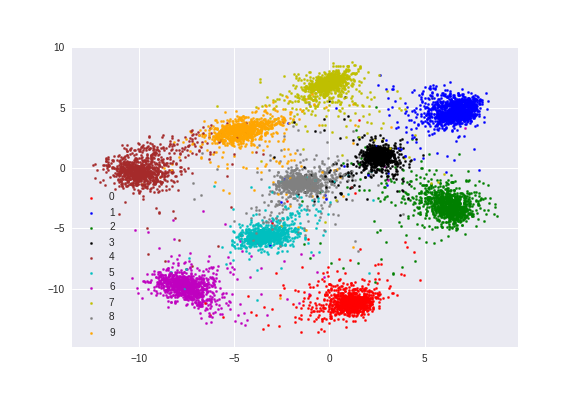

In [21]:
from IPython.display import Image
Image('fig1000.png')